In [1]:
import pandas as pd
import numpy as np
import random 
import os
import json

from sklearn.preprocessing import MinMaxScaler

pd.set_option('display.max_rows', 50)


from functions import sharpe_ratio_calculation, generate_rand_portfolios, select_top_five, join_stocks_crypto, evaluate_clustering_stability, run_clustering_model

c:\Users\Kirill\Documents\Projects\thesis\venv312\Lib\site-packages\tslearn\bases\bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [2]:
cryptos_df = pd.read_csv('cryptos_data_new.csv', index_col='timestamp')
cryptos_df.index = pd.to_datetime(cryptos_df.index)

cryptos_df_weekly = cryptos_df.resample('W').last() #aggregating on a weekly level
cryptos_df_3days = cryptos_df.resample('3D').last()# aggregating on a twice per week basis to arrive at the sweet spot of that 250 (1 year) timeseries length

In [3]:
from functions import test_clustering_metrics
random.seed(42)


n_clusters_list = [2,3,4,5,6,7]
df_with_label_balance = pd.DataFrame()
#linkage_list = ['average', 'complete', 'single']
method = 'kshape'
for window in [1,7,10,14,30,60]:
    for df_dict in [{'weekly': cryptos_df_weekly}, {'3day': cryptos_df_3days}, {'full': cryptos_df}]:
        if method != 'ahc':
            linkage_list = None
        print(f'Doing window size {window} with {list(df_dict.keys())[0]} aggregation')
        output = test_clustering_metrics(df_dict, n_clusters_list, method=method, linkage_list=linkage_list, 
                               return_mode='geometric', window=window, n_init=3)
        df_with_label_balance = pd.concat([df_with_label_balance, output])

df_with_label_balance.to_csv(f'NEW_CLUSTERING_TUNING_FINAL/cryptos_only/{method}.csv', index=False)

Doing window size 1 with weekly aggregation
Doing window size 1 with 3day aggregation
Doing window size 1 with full aggregation
Doing window size 7 with weekly aggregation
Doing window size 7 with 3day aggregation
Doing window size 7 with full aggregation
Doing window size 10 with weekly aggregation
Doing window size 10 with 3day aggregation
Doing window size 10 with full aggregation
Doing window size 14 with weekly aggregation
Doing window size 14 with 3day aggregation
Doing window size 14 with full aggregation
Doing window size 30 with weekly aggregation
Doing window size 30 with 3day aggregation
Doing window size 30 with full aggregation
Doing window size 60 with weekly aggregation
Doing window size 60 with 3day aggregation
Doing window size 60 with full aggregation


In [4]:
#kmeans_results = pd.read_csv('NEW_CLUSTERING_TUNING_FINAL/cryptos_only/kmeans.csv')
kshape_results = pd.read_csv('NEW_CLUSTERING_TUNING_FINAL/cryptos_only/kshape.csv')
#ahc_results = pd.read_csv('NEW_CLUSTERING_TUNING_FINAL/cryptos_only/ahc.csv')

results = pd.concat([kshape_results])

In [5]:
results[['silhouette_norm']] = MinMaxScaler().fit_transform(results[['silhouette_score']])
results['entropy_norm_clusters'] = results['entropy'] / np.log2(results['clusters']) #normalize relative to the K clusters


# Filter on only strong silhouette values and reasonable entropy
results_filtered = results[results['silhouette_norm'] > 0.5]
results_filtered = results_filtered[results_filtered['entropy_norm_clusters'] > 0.6]

# Compute total score: average of silhouette and normalized entropy
#results_filtered['total_score'] = (results_filtered['silhouette_norm'] + results_filtered['entropy_norm_clusters']) / 2

In [6]:
results_filtered

,clusters,silhouette_score,method,linkage,return_mode,window_size,df_mode,inertia,entropy,silhouette_norm,entropy_norm_clusters
0,2,0.167627,kshape,not_applicable,geometric,1,weekly,0.041625,0.7121,0.612494,0.712100
19,3,0.165450,kshape,not_applicable,geometric,7,weekly,0.020337,1.3413,0.608706,0.846266
24,2,0.221014,kshape,not_applicable,geometric,7,3day,0.034804,0.6594,0.705366,0.659400
32,4,0.106730,kshape,not_applicable,geometric,7,full,0.030333,1.2811,0.506556,0.640550
37,3,0.257988,kshape,not_applicable,geometric,10,weekly,0.019415,1.3146,0.769687,0.829420
38,4,0.132504,kshape,not_applicable,geometric,10,weekly,0.018317,1.8163,0.551393,0.908150
40,6,0.114961,kshape,not_applicable,geometric,10,weekly,0.012781,2.0598,0.520874,0.796839
46,6,0.104973,kshape,not_applicable,geometric,10,3day,0.023576,2.0193,0.503501,0.781172
49,3,0.109650,kshape,not_applicable,geometric,10,full,0.031805,1.0383,0.511636,0.655094
55,3,0.293839,kshape,not_applicable,geometric,14,weekly,0.019539,1.3672,0.832054,0.862607


In [7]:
#CLUSTERING STABILITY
from functions import evaluate_clustering_stability
filtered_results_with_stability = results_filtered.copy()
for row in filtered_results_with_stability.iterrows():

    method = row[1]['method']
    linkage = row[1]['linkage']
    window_size = row[1]['window_size']
    n_clusters = row[1]['clusters']
    if row[1]['df_mode'] == '3day':
        agg_level = 3
    elif row[1]['df_mode'] == 'weekly':
        agg_level = 5
    else:
        agg_level = 1

    results = evaluate_clustering_stability(cryptos_df, n_clusters=n_clusters, window_size=252, step_size=30, agg_level=agg_level, smoothing_window=window_size, method=method, linkage=linkage, crypto_only=True)
    if len(results) > 20:
        break
    ari_mean = results['ari'].mean()
    nmi_mean = results['nmi'].mean()

    filtered_results_with_stability.loc[row[0], 'ari_mean'] = ari_mean
    filtered_results_with_stability.loc[row[0], 'nmi_mean'] = nmi_mean

filtered_results_with_stability.to_csv('filtered_results_with_stability_CRYPTOS_ONLY.csv')

In [8]:
filtered_results_with_stability = pd.read_csv('filtered_results_with_stability_CRYPTOS_ONLY.csv')
filtered_results_with_stability['ari_norm'] = MinMaxScaler().fit_transform(filtered_results_with_stability[['ari_mean']])
filtered_results_with_stability['nmi_norm'] = MinMaxScaler().fit_transform(filtered_results_with_stability[['nmi_mean']])
filtered_results_with_stability['stability_score'] = (filtered_results_with_stability['nmi_norm'] + filtered_results_with_stability['ari_norm']) / 2


filtered_results_with_stability['renormalized_silhouette'] = MinMaxScaler().fit_transform(filtered_results_with_stability[['silhouette_score']])
filtered_results_with_stability['renormalized_inertia'] = 1 - MinMaxScaler().fit_transform(filtered_results_with_stability[['inertia']])
filtered_results_with_stability['renormalized_stability'] = 1 - MinMaxScaler().fit_transform(filtered_results_with_stability[['stability_score']])

filtered_results_with_stability['final_score'] = filtered_results_with_stability[['renormalized_silhouette', 'renormalized_inertia', 'renormalized_stability']].mean(axis=1)

In [9]:
filtered_results_with_stability.sort_values('final_score', ascending=False)

,Unnamed: 0,clusters,silhouette_score,method,linkage,return_mode,window_size,df_mode,inertia,entropy,...,entropy_norm_clusters,ari_mean,nmi_mean,ari_norm,nmi_norm,stability_score,renormalized_silhouette,renormalized_inertia,renormalized_stability,final_score
20,79,3,0.309174,kshape,not_applicable,geometric,30,3day,0.017378,1.3374,...,0.843805,0.217759,0.250324,0.417306,0.490037,0.453671,1.000000,0.758410,0.516671,0.758360
31,101,7,0.244537,kshape,not_applicable,geometric,60,3day,0.010720,2.3850,...,0.849554,0.091269,0.359995,0.153644,0.762614,0.458129,0.685376,0.957714,0.511922,0.718337
9,55,3,0.293839,kshape,not_applicable,geometric,14,weekly,0.019539,1.3672,...,0.862607,0.227118,0.248191,0.436815,0.484734,0.460775,0.925356,0.693743,0.509103,0.709400
22,81,5,0.249951,kshape,not_applicable,geometric,30,3day,0.011253,2.0242,...,0.871775,0.153833,0.344028,0.284056,0.722928,0.503492,0.711728,0.941758,0.463593,0.705693
30,100,6,0.210491,kshape,not_applicable,geometric,60,3day,0.013207,2.3494,...,0.908872,0.109322,0.322174,0.191275,0.668612,0.429943,0.519657,0.883258,0.541950,0.648288
19,78,2,0.300994,kshape,not_applicable,geometric,30,3day,0.027425,0.6006,...,0.600600,0.256636,0.215981,0.498345,0.404680,0.451512,0.960186,0.457669,0.518971,0.645609
16,72,2,0.271173,kshape,not_applicable,geometric,30,weekly,0.039137,0.7121,...,0.712100,0.017560,0.053158,0.000000,0.000000,0.000000,0.815029,0.107096,1.000000,0.640708
12,58,6,0.218027,kshape,not_applicable,geometric,14,weekly,0.011318,2.0598,...,0.796839,0.174323,0.406140,0.326767,0.877302,0.602035,0.556338,0.939818,0.358608,0.618255
32,103,3,0.199451,kshape,not_applicable,geometric,60,full,0.017006,1.3146,...,0.829420,0.168859,0.224644,0.315378,0.426211,0.370794,0.465917,0.769543,0.604966,0.613475
4,37,3,0.257988,kshape,not_applicable,geometric,10,weekly,0.019415,1.3146,...,0.829420,0.268186,0.304737,0.522420,0.625276,0.573848,0.750848,0.697442,0.388638,0.612309


In [10]:
# #FINAL SELECTION
# df_with_all_results_filtered = pd.read_csv('RESULTS_WITH_V_MEASURE_CRYPTOS.csv')
# v_measure_cols = [col for col in df_with_all_results_filtered.columns if 'v_measure' in col]
# v_measure_cols.remove('exchange_v_measure')
# df_with_all_results_filtered = df_with_all_results_filtered.drop(columns=['exchange_v_measure'])


# df_with_all_results_filtered['mean_v_measure'] = df_with_all_results_filtered[v_measure_cols].mean(axis=1)
# df_with_all_results_filtered['normalized_mean_v_measure'] = MinMaxScaler().fit_transform(df_with_all_results_filtered[['mean_v_measure']])

# final_selection_clustering = df_with_all_results_filtered.copy()
# # final_selection_clustering = df_with_all_results_filtered[df_with_all_results_filtered['normalized_mean_v_measure'] > 0.5]
# # final_selection_clustering = final_selection_clustering[final_selection_clustering['stability_score'] > 0.5]


# final_selection_clustering['renormalized_silhouette'] = MinMaxScaler().fit_transform(final_selection_clustering[['silhouette_score']])
# final_selection_clustering['renormalized_stability'] = MinMaxScaler().fit_transform(final_selection_clustering[['stability_score']])
# final_selection_clustering['renormalized_v_measure'] = MinMaxScaler().fit_transform(final_selection_clustering[['mean_v_measure']])

# #final_selection_clustering['renormalized_inertia'] = MinMaxScaler().fit_transform(1 - final_selection_clustering[['inertia']]) #ALSO INVERT INERTIA SCORE TO BE HIGHER = BETTER

# final_selection_clustering['final_score'] = final_selection_clustering[['renormalized_silhouette', 'renormalized_stability', 'renormalized_v_measure']].mean(axis=1)

# final_selection_clustering.loc[final_selection_clustering['final_score'].idxmax()]

In [11]:
#3 clus, 3day 30days
#BEST - 2clus weekly 10 days

In [12]:
# import matplotlib.pyplot as plt
# import pandas as pd

# # Sample dictionary
# ticker_cluster_dict = tickers_with_labels_kshape
# # Convert to DataFrame
# df_clusters = pd.DataFrame(list(ticker_cluster_dict.items()), columns=['ticker', 'cluster'])

# # Count number of tickers per cluster
# cluster_counts = df_clusters['cluster'].value_counts().sort_index()

# # Plot
# plt.figure(figsize=(8, 5))
# cluster_counts.plot(kind='bar', color='skyblue', edgecolor='black')
# plt.title('Number of Tickers per Cluster')
# plt.xlabel('Cluster Label')
# plt.ylabel('Number of Tickers')
# plt.xticks(rotation=0)
# plt.grid(axis='y')
# plt.tight_layout()
# plt.show()


In [13]:
coinbase_categories = {
    # Store of Value
    'BTCUSDT': 'Store of Value',
    
    # Smart Contract Platforms  
    'ETHUSDT': 'Smart Contract Platforms',
    'SOLUSDT': 'Smart Contract Platforms', 
    'ADAUSDT': 'Smart Contract Platforms',
    'AVAXUSDT': 'Smart Contract Platforms',
    'NEARUSDT': 'Smart Contract Platforms',
    'ICPUSDT': 'Smart Contract Platforms',
    'ETCUSDT': 'Smart Contract Platforms',
    'ATOMUSDT': 'Smart Contract Platforms',
    'MATICUSDT': 'Smart Contract Platforms',
    'ALGOUSDT': 'Smart Contract Platforms',
    'EOSUSDT': 'Smart Contract Platforms',
    'STXUSDT': 'Smart Contract Platforms',
    'XTZUSDT': 'Smart Contract Platforms',
    'ROSEUSDT': 'Smart Contract Platforms',
    
    # DeFi
    'UNIUSDT': 'DeFi',
    'AAVEUSDT': 'DeFi', 
    'MKRUSDT': 'DeFi',
    'CRVUSDT': 'DeFi',
    'COMPUSDT': 'DeFi',
    '1INCHUSDT': 'DeFi',
    'SNXUSDT': 'DeFi',
    
    # Infrastructure Applications & DePIN
    'LINKUSDT': 'Infrastructure Applications & DePIN',
    'RNDRUSDT': 'Infrastructure Applications & DePIN',
    'INJUSDT': 'Infrastructure Applications & DePIN',
    'GRTUSDT': 'Infrastructure Applications & DePIN',
    'LPTUSDT': 'Infrastructure Applications & DePIN',
    'QNTUSDT': 'Infrastructure Applications & DePIN',
    'DOTUSDT': 'Infrastructure Applications & DePIN',
    
    # Media & Entertainment
    'SANDUSDT': 'Media & Entertainment',
    'MANAUSDT': 'Media & Entertainment', 
    'AXSUSDT': 'Media & Entertainment',
    'CHZUSDT': 'Media & Entertainment',
    'JASMYUSDT': 'Media & Entertainment',
    
    # Payments
    'XRPUSDT': 'Payments',
    'XLMUSDT': 'Payments',
    'LTCUSDT': 'Payments', 
    'BCHUSDT': 'Payments',
    'ZECUSDT': 'Payments',
    
    # Memecoins
    'DOGEUSDT': 'Memecoins',
    'SHIBUSDT': 'Memecoins'
}


In [14]:
from sklearn.metrics import v_measure_score

def clustering_v_measure(cluster_dict:dict, class_dict:dict, method:str):
    try:
        methods_clusters = cluster_dict[method]
    except:
        methods_clusters = cluster_dict.copy()

    common = list(set(methods_clusters) & set(class_dict))

    if not common:
        raise ValueError("No overlapping tickers between clustering and class dictionaries.")

    cluster_labels = [methods_clusters[t] for t in common]
    true_labels = [class_dict[t] for t in common]

    v_measure = v_measure_score(true_labels, cluster_labels)
    
    return v_measure


classes_levels = {'layer': coinbase_categories}


random.seed(42)

df_with_all_results_filtered = filtered_results_with_stability.copy()
for i, row in enumerate(df_with_all_results_filtered.iterrows()):
    method = row[1]['method']
    linkage = row[1]['linkage']
    window_size = row[1]['window_size']
    n_clusters = row[1]['clusters']
    if row[1]['df_mode'] == '3day':
        df = cryptos_df_3days
    elif row[1]['df_mode'] == 'weekly':
        df = cryptos_df_weekly
    else:
        df = cryptos_df
    
    df = df.rolling(window=window_size, center=False).mean().dropna()

    random.seed(42)
    results, tickers_with_labels, _, _ = run_clustering_model(df, n_clus=n_clusters, model_name=method, linkage=linkage, return_mode='geometric', n_init=3)
    for class_name, class_dict in classes_levels.items():
        v_measure = clustering_v_measure(tickers_with_labels, class_dict, method=method)

        col_name = f'{class_name}_v_measure'
        if col_name not in df_with_all_results_filtered.columns:
            df_with_all_results_filtered[col_name] = np.nan
        df_with_all_results_filtered.at[i, col_name] = v_measure

df_with_all_results_filtered.to_csv('RESULTS_WITH_V_MEASURE_CRYPTOS.csv', index=False)


In [15]:
df_with_all_results_filtered.sort_values('layer_v_measure', ascending=False).head(20)

,Unnamed: 0,clusters,silhouette_score,method,linkage,return_mode,window_size,df_mode,inertia,entropy,...,ari_mean,nmi_mean,ari_norm,nmi_norm,stability_score,renormalized_silhouette,renormalized_inertia,renormalized_stability,final_score,layer_v_measure
6,40,6,0.114961,kshape,not_applicable,geometric,10,weekly,0.012781,2.0598,...,0.199804,0.419370,0.379881,0.910185,0.645033,0.054654,0.896011,0.312799,0.421155,0.361636
7,46,6,0.104973,kshape,not_applicable,geometric,10,3day,0.023576,2.0193,...,0.224104,0.414029,0.430532,0.896910,0.663721,0.006042,0.572893,0.292889,0.290608,0.345134
24,88,6,0.109791,kshape,not_applicable,geometric,30,full,0.020336,2.0721,...,0.267458,0.433894,0.520902,0.946282,0.733592,0.029493,0.669875,0.218451,0.305940,0.337648
13,59,7,0.110751,kshape,not_applicable,geometric,14,weekly,0.009307,2.3572,...,0.175369,0.455507,0.328947,1.000000,0.664474,0.034166,1.000000,0.292087,0.442084,0.312982
23,82,6,0.199885,kshape,not_applicable,geometric,30,3day,0.009858,2.0598,...,0.188925,0.417478,0.357204,0.905480,0.631342,0.468028,0.983508,0.327385,0.592974,0.297218
12,58,6,0.218027,kshape,not_applicable,geometric,14,weekly,0.011318,2.0598,...,0.174323,0.406140,0.326767,0.877302,0.602035,0.556338,0.939818,0.358608,0.618255,0.297218
30,100,6,0.210491,kshape,not_applicable,geometric,60,3day,0.013207,2.3494,...,0.109322,0.322174,0.191275,0.668612,0.429943,0.519657,0.883258,0.541950,0.648288,0.293007
0,0,2,0.167627,kshape,not_applicable,geometric,1,weekly,0.041625,0.7121,...,0.471968,0.418610,0.947197,0.908296,0.927746,0.311013,0.032626,0.011604,0.118414,0.290181
15,66,2,0.179542,kshape,not_applicable,geometric,14,full,0.034171,0.7121,...,0.497300,0.406130,1.000000,0.877276,0.938638,0.369009,0.255736,0.000000,0.208248,0.290181
33,106,6,0.103732,kshape,not_applicable,geometric,60,full,0.012195,2.3204,...,0.184102,0.391419,0.347150,0.840715,0.593933,0.000000,0.913567,0.367240,0.426936,0.289112


In [32]:
def visualise_cryptos_in_clusters(ticker_to_class:dict, ticker_to_cluster_all, method, just_cryptos=True, heatmap=False):
    df = pd.DataFrame({
    'Ticker': list(ticker_to_class.keys()),
    'CLASS': [ticker_to_class[t] for t in ticker_to_class],
    'Cluster': [ticker_to_cluster_all[t] for t in ticker_to_class]
    })

    if just_cryptos:
        df = df[df['CLASS'] == 'crypto']

    pivot = df.groupby(['Cluster', 'CLASS']).size().unstack(fill_value=0)
    
    if heatmap:
        sns.heatmap(pivot, annot=True, fmt='d', cmap='YlGnBu')
        plt.title('Heatmap of CLASSES per Cluster')
        plt.xlabel('CLASS')
        plt.ylabel('Cluster')
        plt.tight_layout()
    
    else:
        pivot.plot(kind='bar', stacked=True, colormap='tab20')
        plt.title('CLASS Distribution by Cluster')
        plt.xlabel('Cluster')
        plt.ylabel('Number of Tickers')
        plt.xticks(rotation=0)
        plt.legend(title='CLASS')
        plt.tight_layout()

        
    plt.show()

In [34]:
df = cryptos_df_weekly.rolling(window=14, center=False).mean()
labels, tickers_with_labels_kshape, _, _ = run_clustering_model(df, n_clus=8, model_name='kshape', linkage=None, return_mode='geometric', n_init=3)

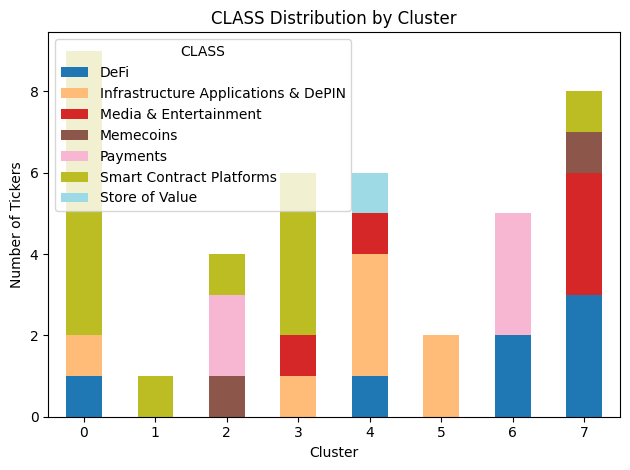

In [35]:
visualise_cryptos_in_clusters(coinbase_categories, tickers_with_labels_kshape, 'kshape', just_cryptos=False, heatmap=False)